# Experiment 06: Rigorous Semantic Priming Hypothesis Test

## Core Question

Does the **semantic content** of a surrogate query improve KV cache document representations
after truncation, or does any prefix text work equally well?

## Primary Baseline

**Bare passage** — the raw passage text with no framing. Matches MS MARCO as closely as possible.

## Experimental Conditions (16 per sample)

| # | Condition | Group | Description |
|---|-----------|-------|-------------|
| 1 | Bare passage | A: Baseline | Raw passage, no framing |
| 2 | Framed passage | A: Baseline | `"Document:\n{passage}"` |
| 3 | Generated (routed) | B: Truncated | Best of 5 by cosine similarity |
| 4 | Generated (oracle) | B: Truncated | Best of 5 by actual answer NLL |
| 5 | Perfect surrogate | B: Truncated | Actual MS MARCO query |
| 6 | Irrelevant query | B: Truncated | Real query from different sample |
| 7 | Shuffled surrogate | B: Truncated | Words randomly shuffled |
| 8 | Random passage | B: Truncated | Different passage as prefix |
| 9 | Random tokens | B: Truncated | Random vocab IDs decoded |
| 10 | Full-ctx generated | C: Full Context | Surrogate kept visible |
| 11 | Full-ctx irrelevant | C: Full Context | Wrong query kept visible |
| 12 | Full-ctx random passage | C: Full Context | Random text kept visible |
| 13 | Pool cosine | D: Routing | Best of 11 by cosine sim |
| 14 | Pool query-NLL | D: Routing | Best of 11 by query NLL |
| 15 | Pool combined | D: Routing | Rank-average of cosine + query NLL |
| 16 | Pool oracle | D: Routing | Best of 11 by answer NLL |

## Key Pairwise Comparisons

| # | Comparison | Question |
|---|-----------|----------|
| 1 | Generated (3) vs Bare (1) | Does surrogate priming help after truncation? |
| 2 | Generated (3) vs Irrelevant (6) | **DECISIVE**: Semantic or structural? |
| 3 | Generated (3) vs Shuffled (7) | Does word order matter? |
| 4 | Generated (3) vs Random passage (8) | Does any coherent text prime equally? |
| 5 | Generated (3) vs Random tokens (9) | Does coherence matter at all? |
| 6 | Framed (2) vs Bare (1) | Does framing help or hurt? |
| 7 | Full-ctx gen (10) vs Full-ctx irrel (11) | Is full-context benefit semantic? |
| 8 | Pool cosine (13) vs Pool query-NLL (14) | Which router is better? |
| 9 | Pool oracle (16) vs Bare (1) | Ceiling for any routing strategy? |

## Experimental Notes

- This experiment was designed after Exp 05 showed truncated caches work mechanically but the semantic signal was unclear (full-context generated surrogates were not significantly different from random prefixes, p=0.45).
- **Key finding:** r=0.924 correlation between generated and shuffled prefix deltas indicates content-independent effects — the improvement from a prefix is almost entirely positional, not semantic.
- **"Document:\n" framing confirmed to hurt** (d=-0.45). Bare documents consistently outperform framed baselines.

## Setup

In [1]:
import sys
import os
import copy
import json
import time
import datetime
import random
from typing import Dict, List, Any, Optional, Tuple

import torch
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt

sys.path.insert(0, '.')

from lib import (
    ExperimentConfig,
    build_kv_cache,
    score_answer_with_cache,
    build_truncated_kv_cache_corrected,
    generate_all_5_surrogates,
    compute_similarity,
    load_evaluation_samples,
    load_ms_marco,
    TOP_5_SURROGATE_TEMPLATES,
    STATIC_SURROGATE_QUERIES,
)
from lib.analysis import cohens_d

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA L4
GPU Memory: 23.6 GB


In [2]:
# Configuration
config = ExperimentConfig(
    num_samples=800,
    min_passage_words=50,
    max_passage_words=300,
    surrogate_max_tokens=45,
    surrogate_temperature=0.3,
    seed=42,
)

print(f"Model: {config.model_name}")
print(f"Samples requested: {config.num_samples}")
print(f"Passage words: {config.min_passage_words}-{config.max_passage_words}")
print(f"Device: {config.device}")

Model: mistralai/Mistral-7B-Instruct-v0.2
Samples requested: 800
Passage words: 50-300
Device: cuda


## Model Loading

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer

torch.manual_seed(config.seed)
np.random.seed(config.seed)
random.seed(config.seed)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

print(f"Loading {config.model_name}...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.eval()
print(f"Model loaded on {config.device}")

print(f"Loading embedding model: {config.embedding_model_name}")
embed_model = SentenceTransformer(config.embedding_model_name)
print("Embedding model loaded.")

Loading mistralai/Mistral-7B-Instruct-v0.2...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded on cuda
Loading embedding model: all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded.


## Dataset

In [4]:
dataset = load_ms_marco(config)
raw_samples = load_evaluation_samples(dataset, config, require_answer=True)
print(f"Raw samples after basic filtering: {len(raw_samples)}")

# Additional filters for this experiment
filtered_samples = []
excluded_ratio = 0
excluded_short_answer = 0

for s in raw_samples:
    # Filter: answer/passage length ratio > 0.5
    if len(s['answer']) / max(len(s['passage']), 1) > 0.5:
        excluded_ratio += 1
        continue
    # Filter: answer tokenizes to < 2 tokens
    answer_ids = tokenizer(s['answer'], return_tensors='pt', add_special_tokens=False)['input_ids']
    if answer_ids.shape[1] < 2:
        excluded_short_answer += 1
        continue
    filtered_samples.append(s)

samples = filtered_samples
print(f"\nFiltering stats:")
print(f"  Excluded (answer/passage ratio > 0.5): {excluded_ratio}")
print(f"  Excluded (answer < 2 tokens):          {excluded_short_answer}")
print(f"  Remaining samples:                     {len(samples)}")

# Sanity check
s = samples[0]
print(f"\nExample sample:")
print(f"  Query:   {s['query'][:100]}...")
print(f"  Passage: {s['passage'][:100]}...")
print(f"  Answer:  {s['answer'][:100]}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'microsoft/ms_marco' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading microsoft/ms_marco dataset...
Dataset loaded: 10047 samples
Filtering samples...


Filtering:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 800 samples
Raw samples after basic filtering: 800

Filtering stats:
  Excluded (answer/passage ratio > 0.5): 62
  Excluded (answer < 2 tokens):          61
  Remaining samples:                     677

Example sample:
  Query:   what is in a cell...
  Passage: That's because all cells are surrounded by a structure called the cell membrane — which, much like t...
  Answer:  Membrane


## Helper Functions

In [5]:
def shuffle_text(text: str, rng: random.Random) -> str:
    """Split text on whitespace, shuffle words, rejoin."""
    words = text.split()
    rng.shuffle(words)
    return ' '.join(words)


def generate_random_tokens(tokenizer, n_tokens: int, rng: random.Random) -> str:
    """Sample random vocabulary IDs and decode as text."""
    vocab_size = tokenizer.vocab_size
    random_ids = [rng.randint(100, vocab_size - 1) for _ in range(n_tokens)]
    return tokenizer.decode(random_ids, skip_special_tokens=True)


def get_irrelevant_query(samples: list, current_idx: int, rng: random.Random) -> str:
    """Get a query from a different sample."""
    other_idx = current_idx
    while other_idx == current_idx:
        other_idx = rng.randint(0, len(samples) - 1)
    return samples[other_idx]['query']


def get_random_passage(samples: list, current_idx: int, rng: random.Random) -> str:
    """Get a passage from a different sample."""
    other_idx = current_idx
    while other_idx == current_idx:
        other_idx = rng.randint(0, len(samples) - 1)
    return samples[other_idx]['passage']


def deep_copy_cache(cache):
    """Deep copy a DynamicCache so mutations don't affect the original."""
    return copy.deepcopy(cache)


def score_query_nll(cache, cache_len: int, query_text: str, model, tokenizer, config) -> float:
    """Score query text NLL under a given cache.

    The cache that best 'predicts' the query is likely best aligned for answering it.
    Uses a deep copy of the cache to avoid mutation.
    """
    cache_copy = deep_copy_cache(cache)

    query_ids = tokenizer(
        query_text, return_tensors="pt", add_special_tokens=False
    )['input_ids'].to(config.device)
    query_len = query_ids.shape[1]

    if query_len < 2:
        return float('inf')

    attention_mask = torch.ones((1, cache_len + query_len), device=config.device)

    with torch.no_grad():
        outputs = model(
            input_ids=query_ids,
            attention_mask=attention_mask,
            past_key_values=cache_copy,
            use_cache=True,
            return_dict=True
        )

    logits = outputs.logits
    shift_logits = logits[:, :-1, :].contiguous().view(-1, logits.size(-1))
    shift_labels = query_ids[:, 1:].contiguous().view(-1)

    loss = torch.nn.CrossEntropyLoss(reduction='sum')
    nll = loss(shift_logits, shift_labels).item()
    return nll / (query_len - 1)


def build_pool_caches(
    passage: str,
    generated_surrogates: Dict[str, str],
    model, tokenizer, config
) -> Dict[str, Tuple[int, Any]]:
    """Build all 11 pool caches: bare + 5 generated + 5 static.

    Returns dict mapping cache_key -> (cache_len, cache_object).
    Each cache is built fresh and NOT scored yet, so it can be reused.
    """
    pool = {}

    # Bare baseline cache
    bare_len, bare_cache = build_kv_cache(passage, model, tokenizer, config)
    pool['bare'] = (bare_len, bare_cache)

    # 5 generated surrogate caches (truncated + corrected)
    for key, surrogate in generated_surrogates.items():
        doc_len, cache = build_truncated_kv_cache_corrected(
            surrogate, passage, model, tokenizer, config
        )
        pool[f'gen_{key}'] = (doc_len, cache)

    # 5 static surrogate caches (truncated + corrected)
    for key, info in STATIC_SURROGATE_QUERIES.items():
        doc_len, cache = build_truncated_kv_cache_corrected(
            info['query'], passage, model, tokenizer, config
        )
        pool[f'static_{key}'] = (doc_len, cache)

    return pool


print("Helper functions defined.")

Helper functions defined.


## Pipeline Verification

Test all 16 conditions on one sample to verify everything works.

In [6]:
test_sample = samples[0]
test_idx = 0
test_rng = random.Random(config.seed)
passage = test_sample['passage']
query = test_sample['query']
answer = test_sample['answer']
query_prompt = config.query_template.format(query=query)

print(f"Passage: {passage[:100]}...")
print(f"Query:   {query}")
print(f"Answer:  {answer[:80]}")
print()

# --- Group A: Baselines ---
# 1. Bare passage
bare_len, bare_cache = build_kv_cache(passage, model, tokenizer, config)
bare_nll = score_answer_with_cache(bare_cache, bare_len, query_prompt, answer, model, tokenizer, config)
print(f"1. Bare passage NLL:      {bare_nll:.4f}")

# 2. Framed passage
framed_ctx = config.baseline_cache_template.format(document=passage)
framed_len, framed_cache = build_kv_cache(framed_ctx, model, tokenizer, config)
framed_nll = score_answer_with_cache(framed_cache, framed_len, query_prompt, answer, model, tokenizer, config)
print(f"2. Framed passage NLL:    {framed_nll:.4f}")

# --- Group B: Truncated + RoPE Corrected ---
# Generate surrogates
test_surrogates = generate_all_5_surrogates(passage, model, tokenizer, config)
test_sims = {k: compute_similarity(v, query, embed_model) for k, v in test_surrogates.items()}
routed_key = max(test_sims, key=test_sims.get)
print(f"\nGenerated surrogates:")
for k, v in test_surrogates.items():
    marker = " <-- routed" if k == routed_key else ""
    print(f"  {k}: \"{v}\" (sim={test_sims[k]:.3f}){marker}")

# 3. Generated (routed)
doc_len, cache = build_truncated_kv_cache_corrected(test_surrogates[routed_key], passage, model, tokenizer, config)
gen_routed_nll = score_answer_with_cache(cache, doc_len, query_prompt, answer, model, tokenizer, config)
print(f"\n3. Generated (routed) NLL: {gen_routed_nll:.4f}")

# 4. Generated (oracle) — need all 5 NLLs
gen_nlls = {}
for k, surr in test_surrogates.items():
    dl, c = build_truncated_kv_cache_corrected(surr, passage, model, tokenizer, config)
    gen_nlls[k] = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)
oracle_key = min(gen_nlls, key=gen_nlls.get)
print(f"4. Generated (oracle) NLL: {gen_nlls[oracle_key]:.4f} (key={oracle_key})")

# 5. Perfect surrogate
dl, c = build_truncated_kv_cache_corrected(query, passage, model, tokenizer, config)
perfect_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)
print(f"5. Perfect surrogate NLL:  {perfect_nll:.4f}")

# 6. Irrelevant query
irrel_query = get_irrelevant_query(samples, test_idx, test_rng)
dl, c = build_truncated_kv_cache_corrected(irrel_query, passage, model, tokenizer, config)
irrel_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)
print(f"6. Irrelevant query NLL:   {irrel_nll:.4f} (query: \"{irrel_query[:50]}\")")

# 7. Shuffled surrogate
shuffled_text = shuffle_text(test_surrogates[routed_key], test_rng)
dl, c = build_truncated_kv_cache_corrected(shuffled_text, passage, model, tokenizer, config)
shuffled_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)
print(f"7. Shuffled surrogate NLL: {shuffled_nll:.4f} (text: \"{shuffled_text[:50]}\")")

# 8. Random passage prefix
rand_passage = get_random_passage(samples, test_idx, test_rng)
dl, c = build_truncated_kv_cache_corrected(rand_passage[:200], passage, model, tokenizer, config)
rand_passage_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)
print(f"8. Random passage NLL:     {rand_passage_nll:.4f}")

# 9. Random tokens
rand_tokens_text = generate_random_tokens(tokenizer, 20, test_rng)
dl, c = build_truncated_kv_cache_corrected(rand_tokens_text, passage, model, tokenizer, config)
rand_tokens_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)
print(f"9. Random tokens NLL:      {rand_tokens_nll:.4f} (text: \"{rand_tokens_text[:50]}\")")

# --- Group C: Full Context ---
# 10. Full-context generated (routed)
full_gen_ctx = config.surrogate_cache_template.format(surrogate=test_surrogates[routed_key], document=passage)
fl, fc = build_kv_cache(full_gen_ctx, model, tokenizer, config)
full_gen_nll = score_answer_with_cache(fc, fl, query_prompt, answer, model, tokenizer, config)
print(f"\n10. Full-ctx generated NLL: {full_gen_nll:.4f}")

# 11. Full-context irrelevant
full_irrel_ctx = config.surrogate_cache_template.format(surrogate=irrel_query, document=passage)
fl, fc = build_kv_cache(full_irrel_ctx, model, tokenizer, config)
full_irrel_nll = score_answer_with_cache(fc, fl, query_prompt, answer, model, tokenizer, config)
print(f"11. Full-ctx irrelevant NLL: {full_irrel_nll:.4f}")

# 12. Full-context random passage
full_rand_ctx = config.surrogate_cache_template.format(surrogate=rand_passage[:200], document=passage)
fl, fc = build_kv_cache(full_rand_ctx, model, tokenizer, config)
full_rand_passage_nll = score_answer_with_cache(fc, fl, query_prompt, answer, model, tokenizer, config)
print(f"12. Full-ctx random pass NLL: {full_rand_passage_nll:.4f}")

# --- Group D: Production Routing Pool ---
print("\nBuilding pool caches (11 total)...")
pool_caches = build_pool_caches(passage, test_surrogates, model, tokenizer, config)

# Compute cosine similarities for pool
pool_sims = {}
pool_sims['bare'] = compute_similarity(passage, query, embed_model)
for k, surr in test_surrogates.items():
    pool_sims[f'gen_{k}'] = compute_similarity(surr, query, embed_model)
for k, info in STATIC_SURROGATE_QUERIES.items():
    pool_sims[f'static_{k}'] = compute_similarity(info['query'], query, embed_model)

# Compute query NLL for pool (using deep copies)
pool_query_nlls = {}
query_text_for_nll = config.query_template.format(query=query)
for cache_key, (clen, cache_obj) in pool_caches.items():
    pool_query_nlls[cache_key] = score_query_nll(cache_obj, clen, query_text_for_nll, model, tokenizer, config)

# Score answer NLL for all pool caches (for oracle + routed lookups)
pool_answer_nlls = {}
for cache_key, (clen, cache_obj) in pool_caches.items():
    # Need deep copy since score_answer_with_cache mutates
    cache_copy = deep_copy_cache(cache_obj)
    pool_answer_nlls[cache_key] = score_answer_with_cache(
        cache_copy, clen, query_prompt, answer, model, tokenizer, config
    )

# 13. Pool routed (cosine sim)
pool_cosine_key = max(pool_sims, key=pool_sims.get)
print(f"\n13. Pool cosine routed:   {pool_answer_nlls[pool_cosine_key]:.4f} (key={pool_cosine_key})")

# 14. Pool routed (query NLL) — lower NLL is better
pool_qnll_key = min(pool_query_nlls, key=pool_query_nlls.get)
print(f"14. Pool query-NLL routed: {pool_answer_nlls[pool_qnll_key]:.4f} (key={pool_qnll_key})")

# 15. Pool routed (combined) — rank-average
from scipy.stats import rankdata
sim_values = np.array([pool_sims[k] for k in pool_caches.keys()])
qnll_values = np.array([pool_query_nlls[k] for k in pool_caches.keys()])
sim_ranks = rankdata(-sim_values)  # higher sim = better = lower rank
qnll_ranks = rankdata(qnll_values)  # lower NLL = better = lower rank
combined_ranks = (sim_ranks + qnll_ranks) / 2
pool_keys_list = list(pool_caches.keys())
pool_combined_key = pool_keys_list[np.argmin(combined_ranks)]
print(f"15. Pool combined routed:  {pool_answer_nlls[pool_combined_key]:.4f} (key={pool_combined_key})")

# 16. Pool oracle (answer NLL)
pool_oracle_key = min(pool_answer_nlls, key=pool_answer_nlls.get)
print(f"16. Pool oracle:           {pool_answer_nlls[pool_oracle_key]:.4f} (key={pool_oracle_key})")

print("\n--- Verification Summary ---")
all_nlls = [bare_nll, framed_nll, gen_routed_nll, gen_nlls[oracle_key], perfect_nll,
            irrel_nll, shuffled_nll, rand_passage_nll, rand_tokens_nll,
            full_gen_nll, full_irrel_nll, full_rand_passage_nll,
            pool_answer_nlls[pool_cosine_key], pool_answer_nlls[pool_qnll_key],
            pool_answer_nlls[pool_combined_key], pool_answer_nlls[pool_oracle_key]]
print(f"All 16 NLLs finite: {all(np.isfinite(x) for x in all_nlls)}")
print(f"NLL range: [{min(all_nlls):.4f}, {max(all_nlls):.4f}]")
print(f"Query NLL range: [{min(pool_query_nlls.values()):.4f}, {max(pool_query_nlls.values()):.4f}]")

Passage: That's because all cells are surrounded by a structure called the cell membrane — which, much like t...
Query:   what is in a cell
Answer:  Membrane

1. Bare passage NLL:      0.1006
2. Framed passage NLL:    0.0444

Generated surrogates:
  target_question: "What is the difference between prokaryotic and eukaryotic cells, specifically in terms of cell membrane and nucleus?" (sim=0.422)
  keyword_query: "cell membrane, plasma membrane, prokaryotes, bacteria, archaea, eukaryotes, nucleus, single cells, amoebae" (sim=0.453)
  symptom_scenario: "Cell structure difference: Single-celled organisms with or without a nucleus" (sim=0.508)
  misconception_negative: "Is a single cell with nucleus not a prokaryote?" (sim=0.521) <-- routed
  messy_realworld: "Help me find: Cell membrane vs nucleus in prokaryotes and eukaryotes asap! Plz explain difference." (sim=0.450)

3. Generated (routed) NLL: 0.0275
4. Generated (oracle) NLL: 0.0243 (key=keyword_query)
5. Perfect surrogate NLL:  0.0564

## Evaluation Function

In [7]:
def evaluate_sample(
    sample: Dict,
    idx: int,
    all_samples: List[Dict],
    model,
    tokenizer,
    embed_model,
    config: ExperimentConfig,
) -> Optional[Dict]:
    """Evaluate a single sample across all 16 experimental conditions."""
    passage = sample['passage']
    query = sample['query']
    answer = sample['answer']
    query_prompt = config.query_template.format(query=query)
    rng = random.Random(config.seed + idx)

    # ==================== GROUP A: BASELINES ====================

    # 1. Bare passage (PRIMARY BASELINE)
    bare_len, bare_cache = build_kv_cache(passage, model, tokenizer, config)
    bare_nll = score_answer_with_cache(
        bare_cache, bare_len, query_prompt, answer, model, tokenizer, config
    )

    # 2. Framed passage
    framed_ctx = config.baseline_cache_template.format(document=passage)
    framed_len, framed_cache = build_kv_cache(framed_ctx, model, tokenizer, config)
    framed_nll = score_answer_with_cache(
        framed_cache, framed_len, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GENERATE SURROGATES ====================

    generated_surrogates = generate_all_5_surrogates(passage, model, tokenizer, config)
    gen_similarities = {
        k: compute_similarity(v, query, embed_model)
        for k, v in generated_surrogates.items()
    }
    gen_routed_key = max(gen_similarities, key=gen_similarities.get)

    # ==================== GROUP B: TRUNCATED + ROPE CORRECTED ====================

    # Score all 5 generated surrogates (truncated)
    gen_nlls = {}
    for key, surrogate in generated_surrogates.items():
        dl, c = build_truncated_kv_cache_corrected(
            surrogate, passage, model, tokenizer, config
        )
        gen_nlls[key] = score_answer_with_cache(
            c, dl, query_prompt, answer, model, tokenizer, config
        )

    # 3. Generated (routed by cosine sim)
    gen_routed_nll = gen_nlls[gen_routed_key]

    # 4. Generated (oracle by NLL)
    gen_oracle_key = min(gen_nlls, key=gen_nlls.get)
    gen_oracle_nll = gen_nlls[gen_oracle_key]

    # 5. Perfect surrogate (actual query)
    dl, c = build_truncated_kv_cache_corrected(query, passage, model, tokenizer, config)
    perfect_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)

    # 6. Irrelevant query
    irrel_query = get_irrelevant_query(all_samples, idx, rng)
    dl, c = build_truncated_kv_cache_corrected(irrel_query, passage, model, tokenizer, config)
    irrel_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)

    # 7. Shuffled surrogate (shuffle words of routed surrogate)
    shuffled_text = shuffle_text(generated_surrogates[gen_routed_key], rng)
    dl, c = build_truncated_kv_cache_corrected(shuffled_text, passage, model, tokenizer, config)
    shuffled_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)

    # 8. Random passage prefix
    rand_passage_text = get_random_passage(all_samples, idx, rng)[:200]
    dl, c = build_truncated_kv_cache_corrected(rand_passage_text, passage, model, tokenizer, config)
    rand_passage_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)

    # 9. Random tokens
    rand_tokens_text = generate_random_tokens(tokenizer, 20, rng)
    dl, c = build_truncated_kv_cache_corrected(rand_tokens_text, passage, model, tokenizer, config)
    rand_tokens_nll = score_answer_with_cache(c, dl, query_prompt, answer, model, tokenizer, config)

    # ==================== GROUP C: FULL CONTEXT ====================

    # 10. Full-context generated (routed)
    full_gen_ctx = config.surrogate_cache_template.format(
        surrogate=generated_surrogates[gen_routed_key], document=passage
    )
    fl, fc = build_kv_cache(full_gen_ctx, model, tokenizer, config)
    full_gen_nll = score_answer_with_cache(fc, fl, query_prompt, answer, model, tokenizer, config)

    # 11. Full-context irrelevant query
    full_irrel_ctx = config.surrogate_cache_template.format(
        surrogate=irrel_query, document=passage
    )
    fl, fc = build_kv_cache(full_irrel_ctx, model, tokenizer, config)
    full_irrel_nll = score_answer_with_cache(fc, fl, query_prompt, answer, model, tokenizer, config)

    # 12. Full-context random passage
    full_rand_ctx = config.surrogate_cache_template.format(
        surrogate=rand_passage_text, document=passage
    )
    fl, fc = build_kv_cache(full_rand_ctx, model, tokenizer, config)
    full_rand_passage_nll = score_answer_with_cache(
        fc, fl, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GROUP D: PRODUCTION ROUTING POOL ====================
    # Build all 11 pool caches: bare + 5 gen + 5 static
    pool_caches = build_pool_caches(passage, generated_surrogates, model, tokenizer, config)

    # Cosine similarities for pool routing
    pool_sims = {}
    pool_sims['bare'] = compute_similarity(passage, query, embed_model)
    for k, surr in generated_surrogates.items():
        pool_sims[f'gen_{k}'] = gen_similarities[k]
    for k, info in STATIC_SURROGATE_QUERIES.items():
        pool_sims[f'static_{k}'] = compute_similarity(info['query'], query, embed_model)

    # Query NLL for pool routing (deep copies to preserve caches)
    query_text_for_nll = config.query_template.format(query=query)
    pool_query_nlls = {}
    for cache_key, (clen, cache_obj) in pool_caches.items():
        pool_query_nlls[cache_key] = score_query_nll(
            cache_obj, clen, query_text_for_nll, model, tokenizer, config
        )

    # Answer NLL for all pool caches (needed for oracle + lookup)
    pool_answer_nlls = {}
    for cache_key, (clen, cache_obj) in pool_caches.items():
        cache_copy = deep_copy_cache(cache_obj)
        pool_answer_nlls[cache_key] = score_answer_with_cache(
            cache_copy, clen, query_prompt, answer, model, tokenizer, config
        )

    # 13. Pool routed (cosine sim)
    pool_cosine_key = max(pool_sims, key=pool_sims.get)
    pool_cosine_nll = pool_answer_nlls[pool_cosine_key]

    # 14. Pool routed (query NLL) — lower is better
    pool_qnll_key = min(pool_query_nlls, key=pool_query_nlls.get)
    pool_qnll_nll = pool_answer_nlls[pool_qnll_key]

    # 15. Pool routed (combined rank-average)
    pool_keys_list = list(pool_caches.keys())
    sim_values = np.array([pool_sims[k] for k in pool_keys_list])
    qnll_values = np.array([pool_query_nlls[k] for k in pool_keys_list])
    from scipy.stats import rankdata
    sim_ranks = rankdata(-sim_values)
    qnll_ranks = rankdata(qnll_values)
    combined_ranks = (sim_ranks + qnll_ranks) / 2
    pool_combined_key = pool_keys_list[int(np.argmin(combined_ranks))]
    pool_combined_nll = pool_answer_nlls[pool_combined_key]

    # 16. Pool oracle (answer NLL)
    pool_oracle_key = min(pool_answer_nlls, key=pool_answer_nlls.get)
    pool_oracle_nll = pool_answer_nlls[pool_oracle_key]

    return {
        'idx': idx,
        'query': query,
        'answer_len': len(answer),
        'passage_len': len(passage),

        # Group A: Baselines
        'bare_nll': bare_nll,
        'framed_nll': framed_nll,

        # Group B: Truncated + RoPE corrected
        'gen_routed_key': gen_routed_key,
        'gen_routed_nll': gen_routed_nll,
        'gen_routed_sim': gen_similarities[gen_routed_key],
        'gen_oracle_key': gen_oracle_key,
        'gen_oracle_nll': gen_oracle_nll,
        'gen_nlls': gen_nlls,
        'gen_similarities': gen_similarities,
        'generated_surrogates': generated_surrogates,
        'perfect_nll': perfect_nll,
        'irrel_nll': irrel_nll,
        'irrel_query': irrel_query,
        'shuffled_nll': shuffled_nll,
        'rand_passage_nll': rand_passage_nll,
        'rand_tokens_nll': rand_tokens_nll,

        # Group C: Full context
        'full_gen_nll': full_gen_nll,
        'full_irrel_nll': full_irrel_nll,
        'full_rand_passage_nll': full_rand_passage_nll,

        # Group D: Pool routing
        'pool_sims': pool_sims,
        'pool_query_nlls': pool_query_nlls,
        'pool_answer_nlls': pool_answer_nlls,
        'pool_cosine_key': pool_cosine_key,
        'pool_cosine_nll': pool_cosine_nll,
        'pool_qnll_key': pool_qnll_key,
        'pool_qnll_nll': pool_qnll_nll,
        'pool_combined_key': pool_combined_key,
        'pool_combined_nll': pool_combined_nll,
        'pool_oracle_key': pool_oracle_key,
        'pool_oracle_nll': pool_oracle_nll,
    }


print("evaluate_sample() defined.")

evaluate_sample() defined.


## Run Experiment

In [8]:
results = []
errors = 0
start_time = time.time()
checkpoint_path = '06_checkpoint.json'

print("=" * 80)
print("RUNNING EXPERIMENT 06: SEMANTIC PRIMING HYPOTHESIS TEST")
print(f"Samples: {len(samples)}, Conditions per sample: 16")
print("=" * 80)

for idx, sample in enumerate(tqdm(samples, desc="Evaluating")):
    try:
        result = evaluate_sample(
            sample, idx, samples, model, tokenizer, embed_model, config
        )
        if result is not None:
            results.append(result)
    except Exception as e:
        errors += 1
        if errors <= 5:
            print(f"\n  Error on sample {idx}: {type(e).__name__}: {e}")
        continue

    # Progress report every 50 samples
    if len(results) > 0 and len(results) % 50 == 0:
        elapsed = time.time() - start_time
        rate = elapsed / len(results)
        remaining = rate * (len(samples) - idx - 1)
        recent = results[-50:]
        bare_mean = np.mean([r['bare_nll'] for r in recent])
        gen_mean = np.mean([r['gen_routed_nll'] for r in recent])
        irrel_mean = np.mean([r['irrel_nll'] for r in recent])
        wr_gen = np.mean([r['bare_nll'] - r['gen_routed_nll'] > 0 for r in recent]) * 100
        wr_irrel = np.mean([r['bare_nll'] - r['irrel_nll'] > 0 for r in recent]) * 100

        print(
            f"\n  [{len(results):>4d} done | {elapsed/60:.0f}m elapsed | ~{remaining/60:.0f}m left]"
            f"\n  Last 50: bare={bare_mean:.3f}  gen_routed={gen_mean:.3f} ({wr_gen:.0f}% win)"
            f"  irrel={irrel_mean:.3f} ({wr_irrel:.0f}% win)"
        )

        # Checkpoint
        with open(checkpoint_path, 'w') as f:
            json.dump({
                'n_done': len(results),
                'n_errors': errors,
                'elapsed': time.time() - start_time,
                'results': results,
            }, f, default=str)

elapsed_total = time.time() - start_time
print(f"\nDone. {len(results)} evaluated, {errors} errors.")
print(f"Total time: {elapsed_total/60:.1f} minutes ({elapsed_total/len(results) if results else 0:.1f}s per sample)")

RUNNING EXPERIMENT 06: SEMANTIC PRIMING HYPOTHESIS TEST
Samples: 677, Conditions per sample: 16


Evaluating:   0%|          | 0/677 [00:00<?, ?it/s]


  [  50 done | 29m elapsed | ~370m left]
  Last 50: bare=0.972  gen_routed=0.929 (64% win)  irrel=0.979 (56% win)

  [ 100 done | 59m elapsed | ~338m left]
  Last 50: bare=1.249  gen_routed=1.129 (78% win)  irrel=1.245 (68% win)

  [ 150 done | 87m elapsed | ~306m left]
  Last 50: bare=1.616  gen_routed=1.510 (62% win)  irrel=1.465 (62% win)

  [ 200 done | 116m elapsed | ~277m left]
  Last 50: bare=1.537  gen_routed=1.455 (66% win)  irrel=1.526 (52% win)

  [ 250 done | 145m elapsed | ~248m left]
  Last 50: bare=1.362  gen_routed=1.325 (56% win)  irrel=1.392 (48% win)

  [ 300 done | 174m elapsed | ~218m left]
  Last 50: bare=1.244  gen_routed=1.245 (56% win)  irrel=1.284 (50% win)

  [ 350 done | 203m elapsed | ~189m left]
  Last 50: bare=1.149  gen_routed=1.352 (48% win)  irrel=1.457 (58% win)

  [ 400 done | 231m elapsed | ~160m left]
  Last 50: bare=1.205  gen_routed=1.114 (62% win)  irrel=1.115 (54% win)

  [ 450 done | 260m elapsed | ~131m left]
  Last 50: bare=1.224  gen_route

## Primary Results

Summary table: all 16 conditions vs bare baseline (primary baseline).

In [9]:
bare_arr = np.array([r['bare_nll'] for r in results])
n = len(results)

conditions = [
    ('1. Bare passage (BASELINE)',   'bare_nll'),
    ('2. Framed passage',            'framed_nll'),
    ('3. Gen routed (cosine)',       'gen_routed_nll'),
    ('4. Gen oracle (NLL)',          'gen_oracle_nll'),
    ('5. Perfect surrogate',         'perfect_nll'),
    ('6. Irrelevant query',          'irrel_nll'),
    ('7. Shuffled surrogate',        'shuffled_nll'),
    ('8. Random passage',            'rand_passage_nll'),
    ('9. Random tokens',             'rand_tokens_nll'),
    ('10. Full-ctx generated',       'full_gen_nll'),
    ('11. Full-ctx irrelevant',      'full_irrel_nll'),
    ('12. Full-ctx random passage',  'full_rand_passage_nll'),
    ('13. Pool cosine',              'pool_cosine_nll'),
    ('14. Pool query-NLL',           'pool_qnll_nll'),
    ('15. Pool combined',            'pool_combined_nll'),
    ('16. Pool oracle',              'pool_oracle_nll'),
]

print("=" * 120)
print("ALL 16 CONDITIONS vs BARE BASELINE (sorted by mean NLL)")
print(f"N = {n} samples. Positive delta = better than bare baseline.")
print("=" * 120)
header = f"{'Condition':<32} {'Mean NLL':>10} {'Std':>8} {'Delta':>10} {'Win%':>8} {'t-stat':>8} {'p-value':>12} {'Cohen d':>10}"
print(header)
print("-" * 120)

rows = []
for label, key in conditions:
    arr = np.array([r[key] for r in results])
    delta = bare_arr - arr
    mean_nll = np.mean(arr)
    std_nll = np.std(arr)
    mean_delta = np.mean(delta)
    win_rate = np.mean(delta > 0) * 100
    if key == 'bare_nll':
        rows.append((mean_nll, label, std_nll, '--', '--', '--', '--', '--'))
    else:
        t, p = stats.ttest_rel(bare_arr, arr)
        d = cohens_d(delta)
        rows.append((mean_nll, label, std_nll, f"{mean_delta:+.4f}", f"{win_rate:.1f}%",
                      f"{t:.3f}", f"{p:.6f}", f"{d:.4f}"))

rows.sort(key=lambda x: x[0])
for mean_nll, label, std_nll, *rest in rows:
    vals = [f"{mean_nll:>10.4f}", f"{std_nll:>8.4f}"] + [f"{v:>12}" if i >= 4 else f"{v:>10}" for i, v in enumerate(rest)]
    print(f"{label:<32} {' '.join(vals)}")

ALL 16 CONDITIONS vs BARE BASELINE (sorted by mean NLL)
N = 677 samples. Positive delta = better than bare baseline.
Condition                          Mean NLL      Std      Delta     Win%   t-stat      p-value    Cohen d
------------------------------------------------------------------------------------------------------------------------
16. Pool oracle                      0.9685   1.3463    +0.2613      74.0%     15.660   0.000000       0.6018
4. Gen oracle (NLL)                  1.0755   1.5102    +0.1543      72.1%      6.938   0.000000       0.2666
8. Random passage                    1.1968   1.6257    +0.0330      63.1%      1.373   0.170212       0.0528
3. Gen routed (cosine)               1.2176   1.6531    +0.0122      60.0%      0.493   0.622158       0.0189
1. Bare passage (BASELINE)           1.2298   1.4935         --         --         --         --           --
13. Pool cosine                      1.2299   1.5982    -0.0001      26.1%     -0.008   0.993671      -0.0

## Semantic Isolation Tests

The decisive comparisons: does the semantic content of the surrogate matter?

In [10]:
# Key pairwise comparisons with Bonferroni correction (5 key tests, alpha=0.01)
alpha = 0.01
n_key_tests = 5
bonferroni_alpha = alpha / n_key_tests

print("=" * 100)
print("SEMANTIC ISOLATION: KEY PAIRWISE COMPARISONS")
print(f"Bonferroni-corrected α = {alpha}/{n_key_tests} = {bonferroni_alpha:.4f}")
print("=" * 100)

pairwise = [
    ("Gen routed (3) vs Bare (1)",          'gen_routed_nll',   'bare_nll',
     "Does surrogate priming help after truncation?"),
    ("Gen routed (3) vs Irrelevant (6)",     'gen_routed_nll',   'irrel_nll',
     "DECISIVE: Semantic or structural?"),
    ("Gen routed (3) vs Shuffled (7)",       'gen_routed_nll',   'shuffled_nll',
     "Does word order matter?"),
    ("Gen routed (3) vs Random passage (8)", 'gen_routed_nll',   'rand_passage_nll',
     "Does any coherent text prime equally?"),
    ("Gen routed (3) vs Random tokens (9)",  'gen_routed_nll',   'rand_tokens_nll',
     "Does coherence matter at all?"),
]

print(f"\n{'Comparison':<42} {'Mean A':>8} {'Mean B':>8} {'Delta':>8} {'t':>8} {'p':>12} {'d':>8} {'Sig?':>6}")
print("-" * 100)

for label, key_a, key_b, question in pairwise:
    a = np.array([r[key_a] for r in results])
    b = np.array([r[key_b] for r in results])
    diff = b - a  # positive = A is better (lower NLL)
    t, p = stats.ttest_rel(a, b)
    d = cohens_d(diff)
    sig = "YES" if p < bonferroni_alpha else "no"
    print(f"{label:<42} {np.mean(a):>8.4f} {np.mean(b):>8.4f} {np.mean(diff):>+8.4f} {t:>8.3f} {p:>12.6f} {d:>8.4f} {sig:>6}")
    print(f"  Q: {question}")

# Additional comparison: framed vs bare
print(f"\n{'='*100}")
print("ADDITIONAL: Framed (2) vs Bare (1)")
framed_arr = np.array([r['framed_nll'] for r in results])
diff = bare_arr - framed_arr
t, p = stats.ttest_rel(bare_arr, framed_arr)
d = cohens_d(diff)
print(f"  Bare mean: {np.mean(bare_arr):.4f}, Framed mean: {np.mean(framed_arr):.4f}")
print(f"  Delta (bare - framed): {np.mean(diff):+.4f}, t={t:.3f}, p={p:.6f}, d={d:.4f}")
if p < 0.05:
    if np.mean(bare_arr) < np.mean(framed_arr):
        print("  -> Bare is significantly better. 'Document:\\n' framing hurts.")
    else:
        print("  -> Framed is significantly better. Framing helps.")
else:
    print("  -> No significant difference between bare and framed.")

SEMANTIC ISOLATION: KEY PAIRWISE COMPARISONS
Bonferroni-corrected α = 0.01/5 = 0.0020

Comparison                                   Mean A   Mean B    Delta        t            p        d   Sig?
----------------------------------------------------------------------------------------------------
Gen routed (3) vs Bare (1)                   1.2176   1.2298  +0.0122   -0.493     0.622158   0.0189     no
  Q: Does surrogate priming help after truncation?
Gen routed (3) vs Irrelevant (6)             1.2176   1.2683  +0.0507   -3.532     0.000441   0.1357    YES
  Q: DECISIVE: Semantic or structural?
Gen routed (3) vs Shuffled (7)               1.2176   1.2304  +0.0127   -1.325     0.185696   0.0509     no
  Q: Does word order matter?
Gen routed (3) vs Random passage (8)         1.2176   1.1968  -0.0209    1.135     0.256654  -0.0436     no
  Q: Does any coherent text prime equally?
Gen routed (3) vs Random tokens (9)          1.2176   1.2873  +0.0696   -5.022     0.000001   0.1930    YES
  

## Full-Context Controls

Is the full-context benefit semantic or positional?

In [11]:
print("=" * 100)
print("FULL-CONTEXT: SEMANTIC vs POSITIONAL")
print("=" * 100)

full_comparisons = [
    ("Full-ctx gen (10) vs Full-ctx irrel (11)",
     'full_gen_nll', 'full_irrel_nll',
     "Is full-context benefit semantic?"),
    ("Full-ctx gen (10) vs Full-ctx random pass (12)",
     'full_gen_nll', 'full_rand_passage_nll',
     "Does coherent-but-wrong text match generated?"),
    ("Full-ctx irrel (11) vs Bare (1)",
     'full_irrel_nll', 'bare_nll',
     "Does any full-context prefix help?"),
    ("Full-ctx random pass (12) vs Bare (1)",
     'full_rand_passage_nll', 'bare_nll',
     "Does random passage prefix help in full context?"),
]

print(f"\n{'Comparison':<50} {'Mean A':>8} {'Mean B':>8} {'Delta':>8} {'t':>8} {'p':>12} {'Sig?':>6}")
print("-" * 100)

for label, key_a, key_b, question in full_comparisons:
    a = np.array([r[key_a] for r in results])
    b = np.array([r[key_b] for r in results])
    diff = b - a
    t, p = stats.ttest_rel(a, b)
    d = cohens_d(diff)
    sig = "YES" if p < 0.05 else "no"
    print(f"{label:<50} {np.mean(a):>8.4f} {np.mean(b):>8.4f} {np.mean(diff):>+8.4f} {t:>8.3f} {p:>12.6f} {sig:>6}")
    print(f"  Q: {question}")

FULL-CONTEXT: SEMANTIC vs POSITIONAL

Comparison                                           Mean A   Mean B    Delta        t            p   Sig?
----------------------------------------------------------------------------------------------------
Full-ctx gen (10) vs Full-ctx irrel (11)             1.2807   1.2464  -0.0343    2.156     0.031470    YES
  Q: Is full-context benefit semantic?
Full-ctx gen (10) vs Full-ctx random pass (12)       1.2807   1.2576  -0.0231    1.451     0.147106     no
  Q: Does coherent-but-wrong text match generated?
Full-ctx irrel (11) vs Bare (1)                      1.2464   1.2298  -0.0167    0.754     0.451315     no
  Q: Does any full-context prefix help?
Full-ctx random pass (12) vs Bare (1)                1.2576   1.2298  -0.0278    1.379     0.168356     no
  Q: Does random passage prefix help in full context?


## Production Routing Comparison

Comparing routers: cosine similarity vs query-NLL vs combined vs oracle.

In [12]:
print("=" * 100)
print("PRODUCTION ROUTING: ROUTER HEAD-TO-HEAD")
print("=" * 100)

routers = [
    ("Pool cosine (13)",   'pool_cosine_nll',   'pool_cosine_key'),
    ("Pool query-NLL (14)", 'pool_qnll_nll',    'pool_qnll_key'),
    ("Pool combined (15)",  'pool_combined_nll', 'pool_combined_key'),
    ("Pool oracle (16)",    'pool_oracle_nll',   'pool_oracle_key'),
]

# Summary stats
print(f"\n{'Router':<25} {'Mean NLL':>10} {'Delta vs Bare':>14} {'Win% vs Bare':>14} {'Chose Bare%':>14}")
print("-" * 80)

for label, nll_key, key_key in routers:
    nlls = np.array([r[nll_key] for r in results])
    delta = bare_arr - nlls
    win_rate = np.mean(delta > 0) * 100
    chose_bare = np.mean([r[key_key] == 'bare' for r in results]) * 100
    print(f"{label:<25} {np.mean(nlls):>10.4f} {np.mean(delta):>+14.4f} {win_rate:>13.1f}% {chose_bare:>13.1f}%")

# Routing efficiency
oracle_delta = np.mean(bare_arr - np.array([r['pool_oracle_nll'] for r in results]))
print(f"\n--- Routing Efficiency (% of oracle's improvement) ---")
for label, nll_key, _ in routers[:3]:
    delta = np.mean(bare_arr - np.array([r[nll_key] for r in results]))
    efficiency = (delta / oracle_delta * 100) if oracle_delta != 0 else 0
    print(f"  {label}: {efficiency:.1f}%")

# Agreement with oracle
print(f"\n--- Agreement with Oracle ---")
for label, _, key_key in routers[:3]:
    agreement = np.mean([r[key_key] == r['pool_oracle_key'] for r in results]) * 100
    print(f"  {label}: {agreement:.1f}%")

# Head-to-head: cosine vs query-NLL
cosine_nlls = np.array([r['pool_cosine_nll'] for r in results])
qnll_nlls = np.array([r['pool_qnll_nll'] for r in results])
t, p = stats.ttest_rel(cosine_nlls, qnll_nlls)
cosine_wins = np.mean(cosine_nlls < qnll_nlls) * 100
print(f"\n--- Cosine vs Query-NLL ---")
print(f"  Cosine mean: {np.mean(cosine_nlls):.4f}, Query-NLL mean: {np.mean(qnll_nlls):.4f}")
print(f"  Cosine wins {cosine_wins:.1f}%, t={t:.3f}, p={p:.6f}")

PRODUCTION ROUTING: ROUTER HEAD-TO-HEAD

Router                      Mean NLL  Delta vs Bare   Win% vs Bare    Chose Bare%
--------------------------------------------------------------------------------
Pool cosine (13)              1.2299        -0.0001          26.1%          56.6%
Pool query-NLL (14)           1.2624        -0.0327          36.0%          31.9%
Pool combined (15)            1.2482        -0.0185          27.6%          53.0%
Pool oracle (16)              0.9685        +0.2613          74.0%          26.0%

--- Routing Efficiency (% of oracle's improvement) ---
  Pool cosine (13): -0.1%
  Pool query-NLL (14): -12.5%
  Pool combined (15): -7.1%

--- Agreement with Oracle ---
  Pool cosine (13): 18.3%
  Pool query-NLL (14): 11.8%
  Pool combined (15): 17.3%

--- Cosine vs Query-NLL ---
  Cosine mean: 1.2299, Query-NLL mean: 1.2624
  Cosine wins 43.4%, t=-1.931, p=0.053881


## Stratified Analysis

In [13]:
# Stratify by difficulty (bare baseline NLL quartiles)
quartiles = np.percentile(bare_arr, [25, 50, 75])
difficulty_bins = [
    ('Q1 (easiest)', lambda x: x <= quartiles[0]),
    ('Q2',           lambda x: quartiles[0] < x <= quartiles[1]),
    ('Q3',           lambda x: quartiles[1] < x <= quartiles[2]),
    ('Q4 (hardest)', lambda x: x > quartiles[2]),
]

print("=" * 120)
print("STRATIFIED BY DIFFICULTY (bare baseline NLL quartiles)")
print("=" * 120)
print(f"{'Quartile':<16} {'N':>5} {'Bare':>8} {'Framed':>8} {'GenRtd':>8} {'GenRtd%':>8} {'Irrel':>8} {'Irrel%':>8} {'Shuf':>8} {'RandP':>8} {'RandT':>8} {'Perf':>8}")
print("-" * 120)

for label, cond in difficulty_bins:
    subset = [r for r in results if cond(r['bare_nll'])]
    if not subset:
        continue
    n_sub = len(subset)
    bare = np.mean([r['bare_nll'] for r in subset])
    framed = np.mean([r['framed_nll'] for r in subset])
    gen = np.mean([r['gen_routed_nll'] for r in subset])
    gen_wr = np.mean([r['bare_nll'] - r['gen_routed_nll'] > 0 for r in subset]) * 100
    irrel = np.mean([r['irrel_nll'] for r in subset])
    irrel_wr = np.mean([r['bare_nll'] - r['irrel_nll'] > 0 for r in subset]) * 100
    shuf = np.mean([r['shuffled_nll'] for r in subset])
    rp = np.mean([r['rand_passage_nll'] for r in subset])
    rt = np.mean([r['rand_tokens_nll'] for r in subset])
    perf = np.mean([r['perfect_nll'] for r in subset])
    print(f"{label:<16} {n_sub:>5} {bare:>8.3f} {framed:>8.3f} {gen:>8.3f} {gen_wr:>7.1f}% {irrel:>8.3f} {irrel_wr:>7.1f}% {shuf:>8.3f} {rp:>8.3f} {rt:>8.3f} {perf:>8.3f}")

# Stratify by similarity bands
print(f"\n{'='*100}")
print("STRATIFIED BY SURROGATE-QUERY SIMILARITY")
print("=" * 100)
sim_bins = [
    ('Low (<0.4)',     lambda r: r['gen_routed_sim'] < 0.4),
    ('Medium (0.4-0.7)', lambda r: 0.4 <= r['gen_routed_sim'] < 0.7),
    ('High (>0.7)',    lambda r: r['gen_routed_sim'] >= 0.7),
]

print(f"{'Band':<20} {'N':>5} {'Bare':>8} {'GenRtd':>8} {'Delta':>8} {'Win%':>8} {'Irrel':>8} {'IrrelDelta':>10}")
print("-" * 80)
for label, cond in sim_bins:
    subset = [r for r in results if cond(r)]
    if not subset:
        print(f"{label:<20} {'(no samples)':>5}")
        continue
    bare_s = np.mean([r['bare_nll'] for r in subset])
    gen_s = np.mean([r['gen_routed_nll'] for r in subset])
    delta_s = np.mean([r['bare_nll'] - r['gen_routed_nll'] for r in subset])
    wr = np.mean([r['bare_nll'] - r['gen_routed_nll'] > 0 for r in subset]) * 100
    irrel_s = np.mean([r['irrel_nll'] for r in subset])
    irrel_delta = np.mean([r['bare_nll'] - r['irrel_nll'] for r in subset])
    print(f"{label:<20} {len(subset):>5} {bare_s:>8.3f} {gen_s:>8.3f} {delta_s:>+8.3f} {wr:>7.1f}% {irrel_s:>8.3f} {irrel_delta:>+10.3f}")

STRATIFIED BY DIFFICULTY (bare baseline NLL quartiles)
Quartile             N     Bare   Framed   GenRtd  GenRtd%    Irrel   Irrel%     Shuf    RandP    RandT     Perf
------------------------------------------------------------------------------------------------------------------------
Q1 (easiest)       170    0.100    0.184    0.122    63.5%    0.143    57.6%    0.132    0.131    0.149    0.154
Q2                 169    0.482    0.661    0.454    64.5%    0.502    52.7%    0.455    0.424    0.499    0.525
Q3                 169    1.082    1.391    1.020    57.4%    1.063    54.4%    1.012    0.997    1.072    1.077
Q4 (hardest)       169    3.262    3.942    3.280    54.4%    3.372    47.3%    3.329    3.242    3.435    3.391

STRATIFIED BY SURROGATE-QUERY SIMILARITY
Band                     N     Bare   GenRtd    Delta     Win%    Irrel IrrelDelta
--------------------------------------------------------------------------------
Low (<0.4)              10    0.782    0.741   +0.040

## Correlation and Regression

In [14]:
from sklearn.linear_model import LinearRegression

# Correlation: surrogate-query similarity vs NLL delta
gen_sims = np.array([r['gen_routed_sim'] for r in results])
gen_deltas = np.array([r['bare_nll'] - r['gen_routed_nll'] for r in results])
difficulty = bare_arr.copy()
answer_lens = np.array([r['answer_len'] for r in results])

print("=" * 80)
print("CORRELATION: SIMILARITY vs NLL DELTA")
print("=" * 80)

r_sim, p_sim = stats.pearsonr(gen_sims, gen_deltas)
print(f"Similarity vs Delta:  r={r_sim:.3f}, p={p_sim:.6f}")

r_diff, p_diff = stats.pearsonr(difficulty, gen_deltas)
print(f"Difficulty vs Delta:  r={r_diff:.3f}, p={p_diff:.6f}")

r_alen, p_alen = stats.pearsonr(answer_lens, gen_deltas)
print(f"Answer len vs Delta:  r={r_alen:.3f}, p={p_alen:.6f}")

# Regression: delta ~ similarity + difficulty + answer_length
print(f"\n{'='*80}")
print("REGRESSION: delta ~ similarity + difficulty + answer_length")
print("=" * 80)

X = np.column_stack([gen_sims, difficulty, answer_lens])
y = gen_deltas
reg = LinearRegression().fit(X, y)
print(f"R² = {reg.score(X, y):.4f}")
print(f"Coefficients:")
for name, coef in zip(['similarity', 'difficulty', 'answer_length'], reg.coef_):
    print(f"  {name:>15}: {coef:+.4f}")
print(f"  {'intercept':>15}: {reg.intercept_:+.4f}")

# Bootstrap 95% CIs (10k resamples)
print(f"\n{'='*80}")
print("BOOTSTRAP 95% CIs FOR KEY DELTAS (10,000 resamples)")
print("=" * 80)

def bootstrap_ci(data, n_boot=10000, ci=0.95):
    boot_means = np.array([
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_boot)
    ])
    lower = np.percentile(boot_means, (1 - ci) / 2 * 100)
    upper = np.percentile(boot_means, (1 + ci) / 2 * 100)
    return lower, upper

np.random.seed(config.seed)
for label, key in [
    ("Gen routed vs Bare",     'gen_routed_nll'),
    ("Irrelevant vs Bare",     'irrel_nll'),
    ("Shuffled vs Bare",       'shuffled_nll'),
    ("Random passage vs Bare", 'rand_passage_nll'),
    ("Random tokens vs Bare",  'rand_tokens_nll'),
    ("Perfect vs Bare",        'perfect_nll'),
    ("Pool oracle vs Bare",    'pool_oracle_nll'),
]:
    deltas = np.array([r['bare_nll'] - r[key] for r in results])
    lo, hi = bootstrap_ci(deltas)
    print(f"  {label:<28}: mean={np.mean(deltas):+.4f}  95% CI=[{lo:+.4f}, {hi:+.4f}]")

CORRELATION: SIMILARITY vs NLL DELTA
Similarity vs Delta:  r=-0.029, p=0.447207
Difficulty vs Delta:  r=-0.048, p=0.212892
Answer len vs Delta:  r=0.079, p=0.040345

REGRESSION: delta ~ similarity + difficulty + answer_length
R² = 0.0079
Coefficients:
       similarity: -0.1537
       difficulty: -0.0138
    answer_length: +0.0006
        intercept: +0.0894

BOOTSTRAP 95% CIs FOR KEY DELTAS (10,000 resamples)
  Gen routed vs Bare          : mean=+0.0122  95% CI=[-0.0380, +0.0591]
  Irrelevant vs Bare          : mean=-0.0385  95% CI=[-0.0871, +0.0081]
  Shuffled vs Bare            : mean=-0.0006  95% CI=[-0.0497, +0.0472]
  Random passage vs Bare      : mean=+0.0330  95% CI=[-0.0163, +0.0784]
  Random tokens vs Bare       : mean=-0.0575  95% CI=[-0.1053, -0.0111]
  Perfect vs Bare             : mean=-0.0552  95% CI=[-0.1003, -0.0102]
  Pool oracle vs Bare         : mean=+0.2613  95% CI=[+0.2293, +0.2950]


## Per-Template Analysis

In [15]:
print("=" * 100)
print("PER-TEMPLATE BREAKDOWN: GENERATED SURROGATES (truncated)")
print("=" * 100)
print(f"{'Template':<28} {'Mean NLL':>10} {'Delta':>10} {'Win%':>8} {'Routed':>8} {'Oracle':>8}")
print("-" * 80)
for key in TOP_5_SURROGATE_TEMPLATES.keys():
    nlls = [r['gen_nlls'][key] for r in results]
    deltas = [r['bare_nll'] - r['gen_nlls'][key] for r in results]
    times_routed = sum(1 for r in results if r['gen_routed_key'] == key)
    times_oracle = sum(1 for r in results if r['gen_oracle_key'] == key)
    print(f"{key:<28} {np.mean(nlls):>10.4f} {np.mean(deltas):>+10.4f} {np.mean([d > 0 for d in deltas])*100:>7.1f}% {times_routed:>8d} {times_oracle:>8d}")

print(f"\n{'='*100}")
print("PER-TEMPLATE BREAKDOWN: STATIC SURROGATES (in pool)")
print("=" * 100)
print(f"{'Template':<28} {'Mean NLL':>10} {'Delta':>10} {'Win%':>8}")
print("-" * 60)
for key in STATIC_SURROGATE_QUERIES.keys():
    nlls = [r['pool_answer_nlls'][f'static_{key}'] for r in results]
    deltas = [r['bare_nll'] - r['pool_answer_nlls'][f'static_{key}'] for r in results]
    print(f"{key:<28} {np.mean(nlls):>10.4f} {np.mean(deltas):>+10.4f} {np.mean([d > 0 for d in deltas])*100:>7.1f}%")

# Routing efficiency per router
print(f"\n{'='*100}")
print("POOL ROUTING: WHICH CACHES GET SELECTED?")
print("=" * 100)
for router_label, key_field in [("Cosine", 'pool_cosine_key'), ("Query-NLL", 'pool_qnll_key'),
                                  ("Combined", 'pool_combined_key'), ("Oracle", 'pool_oracle_key')]:
    print(f"\n  --- {router_label} Router ---")
    from collections import Counter
    counts = Counter(r[key_field] for r in results)
    for k, c in counts.most_common():
        print(f"    {k:<30}: {c:>5} ({c/len(results)*100:.1f}%)")

PER-TEMPLATE BREAKDOWN: GENERATED SURROGATES (truncated)
Template                       Mean NLL      Delta     Win%   Routed   Oracle
--------------------------------------------------------------------------------
target_question                  1.2048    +0.0250    61.0%      346      156
keyword_query                    1.2507    -0.0210    57.5%      105      100
symptom_scenario                 1.2261    +0.0036    57.9%       86      118
misconception_negative           1.2102    +0.0195    59.8%       69      154
messy_realworld                  1.2262    +0.0036    58.9%       71      149

PER-TEMPLATE BREAKDOWN: STATIC SURROGATES (in pool)
Template                       Mean NLL      Delta     Win%
------------------------------------------------------------
static_definitional              1.3479    -0.1182    45.3%
static_procedural                1.2896    -0.0599    48.9%
static_quantitative              1.2530    -0.0232    52.9%
static_factual                   1.2560 

## Visualization

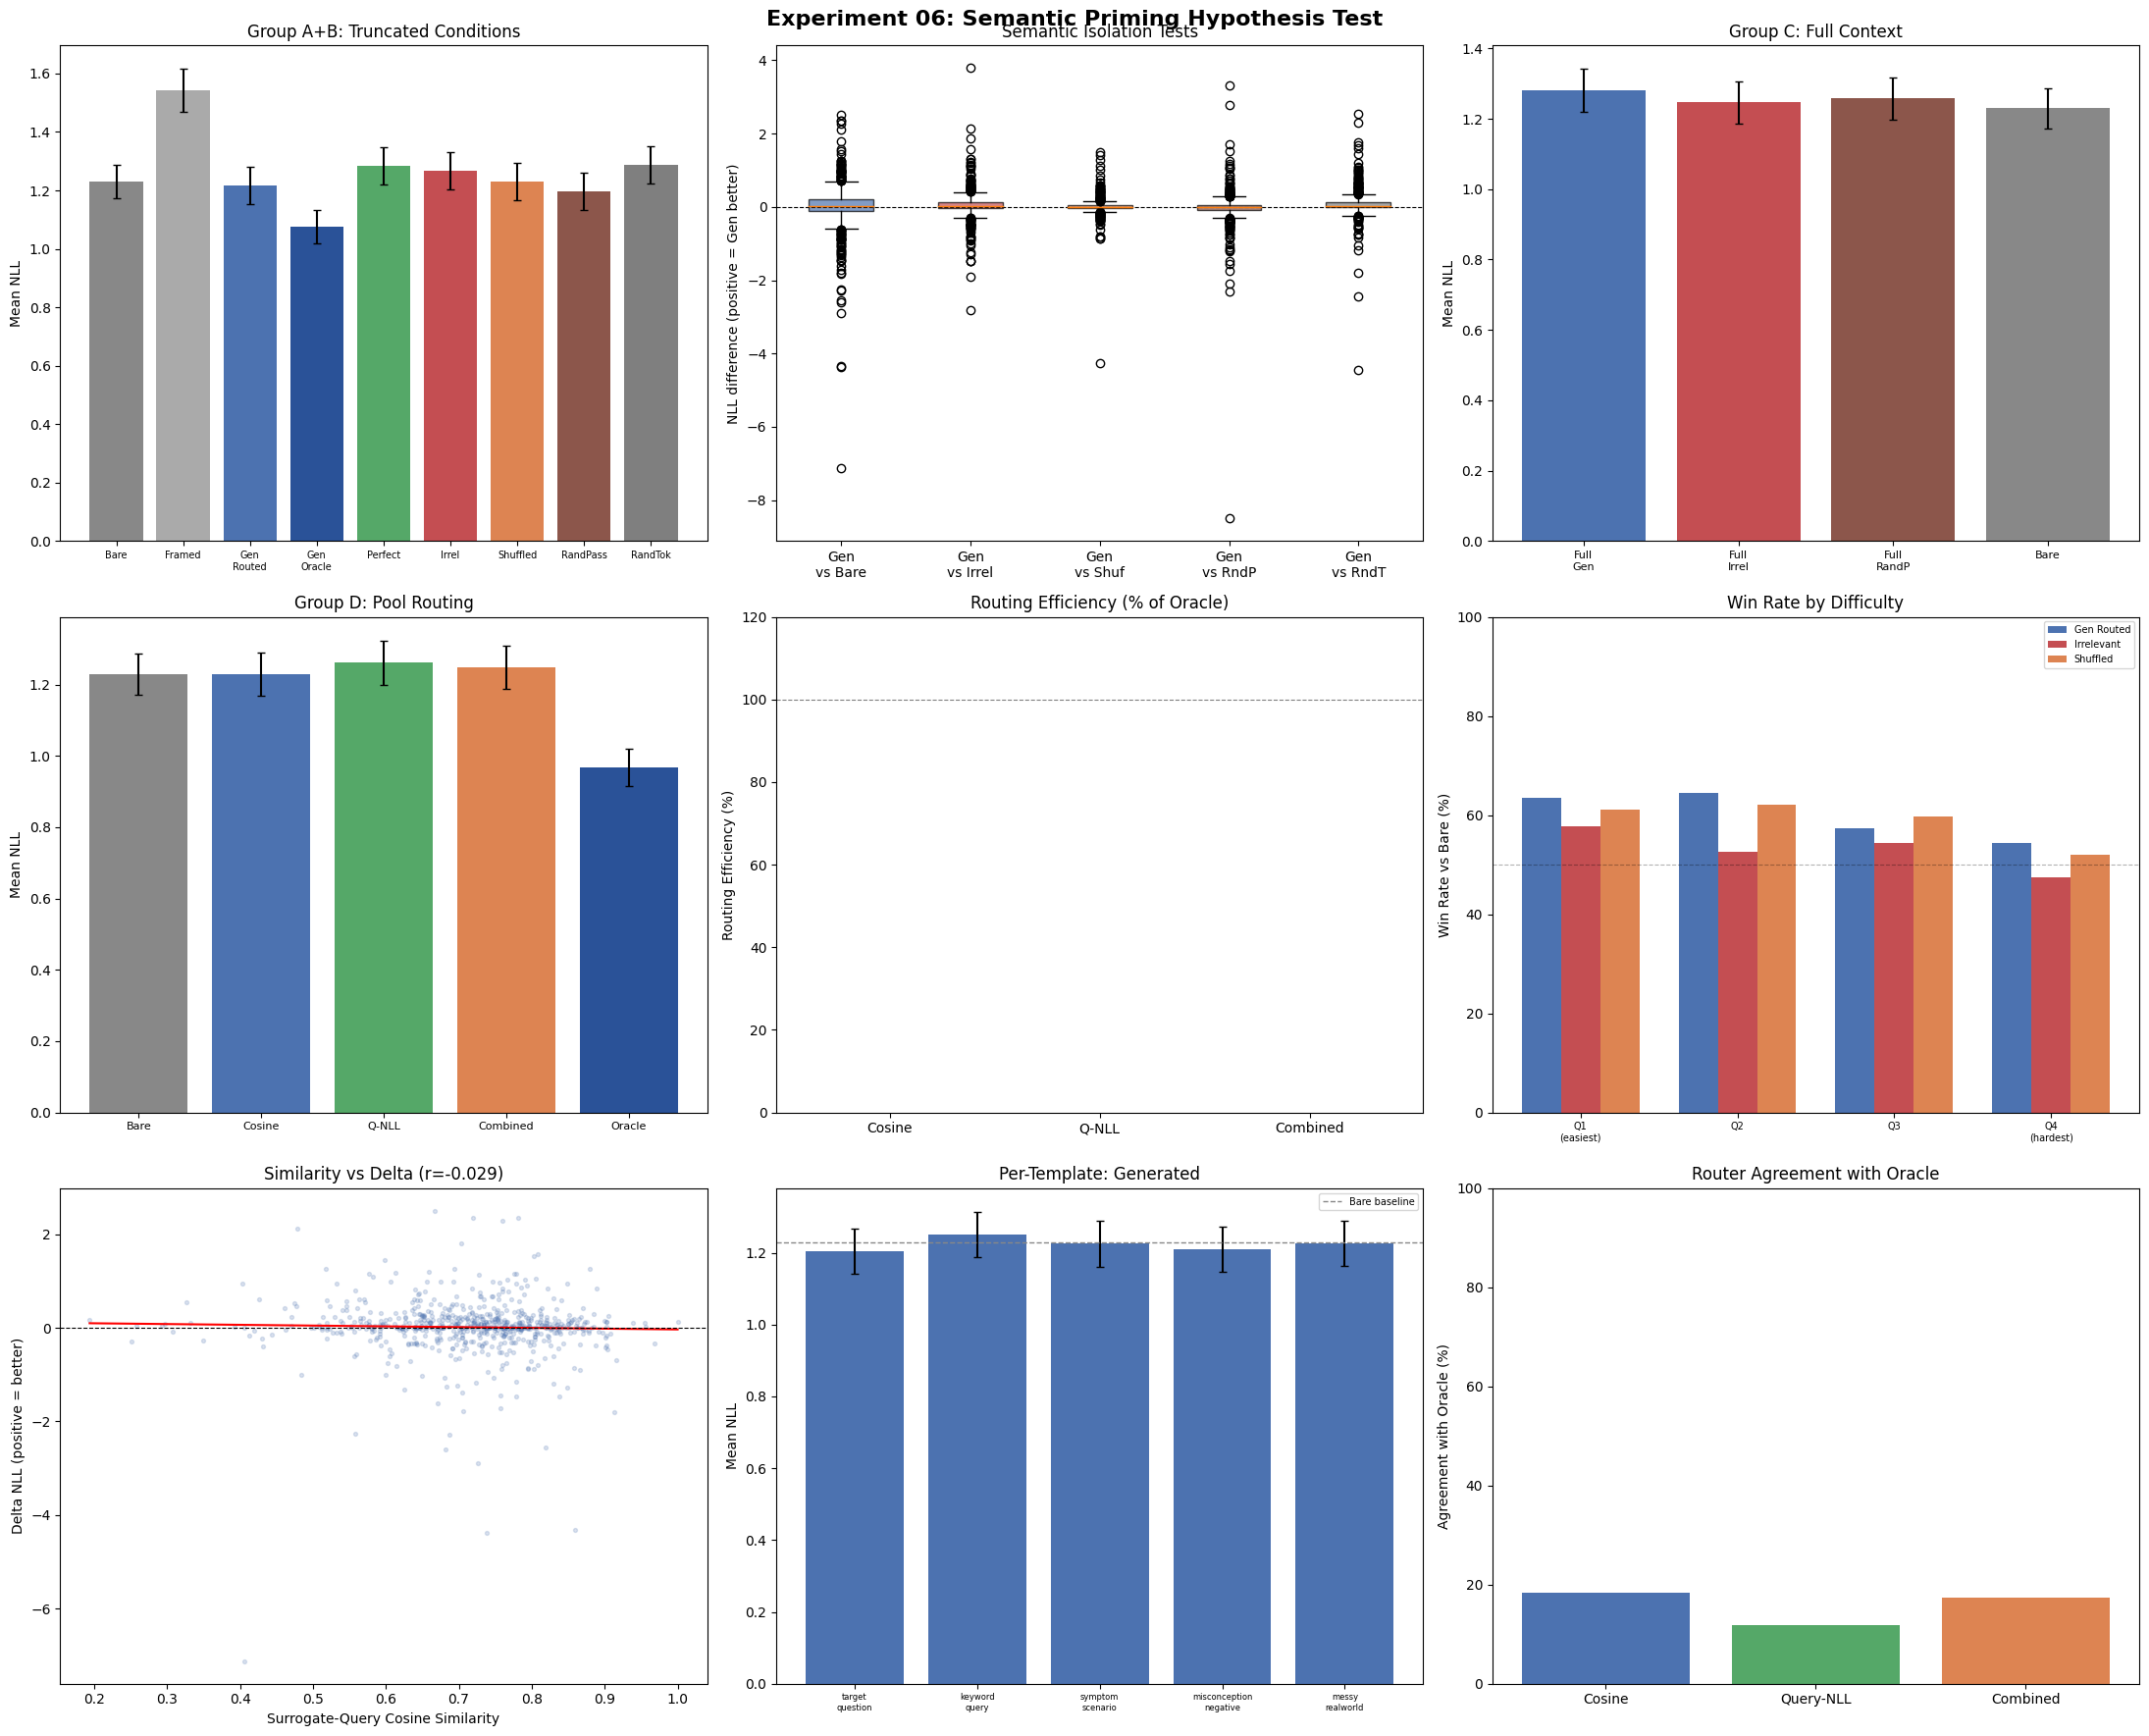

Saved: 06_semantic_priming_results.png


In [16]:
fig, axes = plt.subplots(3, 3, figsize=(22, 18))
fig.suptitle('Experiment 06: Semantic Priming Hypothesis Test', fontsize=16, fontweight='bold')

# --- (0,0) All conditions bar chart ---
ax = axes[0, 0]
cond_order = [
    ('Bare', 'bare_nll'),
    ('Framed', 'framed_nll'),
    ('Gen\nRouted', 'gen_routed_nll'),
    ('Gen\nOracle', 'gen_oracle_nll'),
    ('Perfect', 'perfect_nll'),
    ('Irrel', 'irrel_nll'),
    ('Shuffled', 'shuffled_nll'),
    ('RandPass', 'rand_passage_nll'),
    ('RandTok', 'rand_tokens_nll'),
]
means = [np.mean([r[k] for r in results]) for _, k in cond_order]
sems = [stats.sem([r[k] for r in results]) for _, k in cond_order]
colors = ['#888888', '#aaaaaa', '#4c72b0', '#2a5298', '#55a868',
          '#c44e52', '#dd8452', '#8c564b', '#7f7f7f']
bars = ax.bar(range(len(cond_order)), means, yerr=sems, color=colors, capsize=3)
ax.set_xticks(range(len(cond_order)))
ax.set_xticklabels([l for l, _ in cond_order], fontsize=7)
ax.set_ylabel('Mean NLL')
ax.set_title('Group A+B: Truncated Conditions')

# --- (0,1) Semantic isolation: paired deltas ---
ax = axes[0, 1]
labels_iso = ['Gen\nvs Bare', 'Gen\nvs Irrel', 'Gen\nvs Shuf', 'Gen\nvs RndP', 'Gen\nvs RndT']
data_iso = [
    np.array([r['bare_nll'] - r['gen_routed_nll'] for r in results]),
    np.array([r['irrel_nll'] - r['gen_routed_nll'] for r in results]),
    np.array([r['shuffled_nll'] - r['gen_routed_nll'] for r in results]),
    np.array([r['rand_passage_nll'] - r['gen_routed_nll'] for r in results]),
    np.array([r['rand_tokens_nll'] - r['gen_routed_nll'] for r in results]),
]
bp = ax.boxplot(data_iso, labels=labels_iso, patch_artist=True)
box_colors = ['#4c72b0', '#c44e52', '#dd8452', '#8c564b', '#7f7f7f']
for patch, c in zip(bp['boxes'], box_colors):
    patch.set_facecolor(c)
    patch.set_alpha(0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('NLL difference (positive = Gen better)')
ax.set_title('Semantic Isolation Tests')

# --- (0,2) Full-context comparisons ---
ax = axes[0, 2]
fc_labels = ['Full\nGen', 'Full\nIrrel', 'Full\nRandP', 'Bare']
fc_means = [np.mean([r[k] for r in results]) for k in ['full_gen_nll', 'full_irrel_nll', 'full_rand_passage_nll', 'bare_nll']]
fc_sems = [stats.sem([r[k] for r in results]) for k in ['full_gen_nll', 'full_irrel_nll', 'full_rand_passage_nll', 'bare_nll']]
fc_colors = ['#4c72b0', '#c44e52', '#8c564b', '#888888']
ax.bar(range(4), fc_means, yerr=fc_sems, color=fc_colors, capsize=3)
ax.set_xticks(range(4))
ax.set_xticklabels(fc_labels, fontsize=8)
ax.set_ylabel('Mean NLL')
ax.set_title('Group C: Full Context')

# --- (1,0) Pool routing comparison ---
ax = axes[1, 0]
pool_labels = ['Bare', 'Cosine', 'Q-NLL', 'Combined', 'Oracle']
pool_keys = ['bare_nll', 'pool_cosine_nll', 'pool_qnll_nll', 'pool_combined_nll', 'pool_oracle_nll']
pool_means = [np.mean([r[k] for r in results]) for k in pool_keys]
pool_sems = [stats.sem([r[k] for r in results]) for k in pool_keys]
pool_colors = ['#888888', '#4c72b0', '#55a868', '#dd8452', '#2a5298']
ax.bar(range(5), pool_means, yerr=pool_sems, color=pool_colors, capsize=3)
ax.set_xticks(range(5))
ax.set_xticklabels(pool_labels, fontsize=8)
ax.set_ylabel('Mean NLL')
ax.set_title('Group D: Pool Routing')

# --- (1,1) Routing efficiency ---
ax = axes[1, 1]
oracle_deltas = np.array([r['bare_nll'] - r['pool_oracle_nll'] for r in results])
cosine_deltas = np.array([r['bare_nll'] - r['pool_cosine_nll'] for r in results])
qnll_deltas = np.array([r['bare_nll'] - r['pool_qnll_nll'] for r in results])
combined_deltas = np.array([r['bare_nll'] - r['pool_combined_nll'] for r in results])

efficiencies = []
for name, deltas in [('Cosine', cosine_deltas), ('Q-NLL', qnll_deltas), ('Combined', combined_deltas)]:
    eff = np.mean(deltas) / np.mean(oracle_deltas) * 100 if np.mean(oracle_deltas) != 0 else 0
    efficiencies.append((name, eff))

ax.bar([e[0] for e in efficiencies], [e[1] for e in efficiencies],
       color=['#4c72b0', '#55a868', '#dd8452'])
ax.axhline(100, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_ylabel('Routing Efficiency (%)')
ax.set_title('Routing Efficiency (% of Oracle)')
ax.set_ylim(0, 120)

# --- (1,2) Win rate by difficulty quartile ---
ax = axes[1, 2]
q_labels_list = []
q_gen_wr = []
q_irrel_wr = []
q_shuf_wr = []
for label, cond in difficulty_bins:
    subset = [r for r in results if cond(r['bare_nll'])]
    if not subset:
        continue
    q_labels_list.append(label.replace(' ', '\n'))
    q_gen_wr.append(np.mean([r['bare_nll'] - r['gen_routed_nll'] > 0 for r in subset]) * 100)
    q_irrel_wr.append(np.mean([r['bare_nll'] - r['irrel_nll'] > 0 for r in subset]) * 100)
    q_shuf_wr.append(np.mean([r['bare_nll'] - r['shuffled_nll'] > 0 for r in subset]) * 100)

x_pos = np.arange(len(q_labels_list))
w = 0.25
ax.bar(x_pos - w, q_gen_wr, w, label='Gen Routed', color='#4c72b0')
ax.bar(x_pos, q_irrel_wr, w, label='Irrelevant', color='#c44e52')
ax.bar(x_pos + w, q_shuf_wr, w, label='Shuffled', color='#dd8452')
ax.axhline(50, color='black', linestyle='--', linewidth=0.8, alpha=0.3)
ax.set_xticks(x_pos)
ax.set_xticklabels(q_labels_list, fontsize=7)
ax.set_ylabel('Win Rate vs Bare (%)')
ax.set_title('Win Rate by Difficulty')
ax.legend(fontsize=7)
ax.set_ylim(0, 100)

# --- (2,0) Similarity vs delta scatter ---
ax = axes[2, 0]
ax.scatter(gen_sims, gen_deltas, alpha=0.2, s=8, c='#4c72b0')
z = np.polyfit(gen_sims, gen_deltas, 1)
p_line = np.poly1d(z)
x_range = np.linspace(gen_sims.min(), gen_sims.max(), 100)
ax.plot(x_range, p_line(x_range), 'r-', linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Surrogate-Query Cosine Similarity')
ax.set_ylabel('Delta NLL (positive = better)')
ax.set_title(f'Similarity vs Delta (r={r_sim:.3f})')

# --- (2,1) Per-template NLL (generated) ---
ax = axes[2, 1]
gen_keys = list(TOP_5_SURROGATE_TEMPLATES.keys())
gen_template_means = [np.mean([r['gen_nlls'][k] for r in results]) for k in gen_keys]
gen_template_sems = [stats.sem([r['gen_nlls'][k] for r in results]) for k in gen_keys]
bars = ax.bar(range(len(gen_keys)), gen_template_means, yerr=gen_template_sems,
              color='#4c72b0', capsize=3)
ax.axhline(np.mean(bare_arr), color='#888888', linestyle='--', linewidth=1, label='Bare baseline')
ax.set_xticks(range(len(gen_keys)))
ax.set_xticklabels([k.replace('_', '\n') for k in gen_keys], fontsize=6)
ax.set_ylabel('Mean NLL')
ax.set_title('Per-Template: Generated')
ax.legend(fontsize=7)

# --- (2,2) Router agreement with oracle ---
ax = axes[2, 2]
router_names = ['Cosine', 'Query-NLL', 'Combined']
router_keys = ['pool_cosine_key', 'pool_qnll_key', 'pool_combined_key']
agreements = [np.mean([r[k] == r['pool_oracle_key'] for r in results]) * 100 for k in router_keys]
ax.bar(router_names, agreements, color=['#4c72b0', '#55a868', '#dd8452'])
ax.set_ylabel('Agreement with Oracle (%)')
ax.set_title('Router Agreement with Oracle')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('06_semantic_priming_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 06_semantic_priming_results.png")

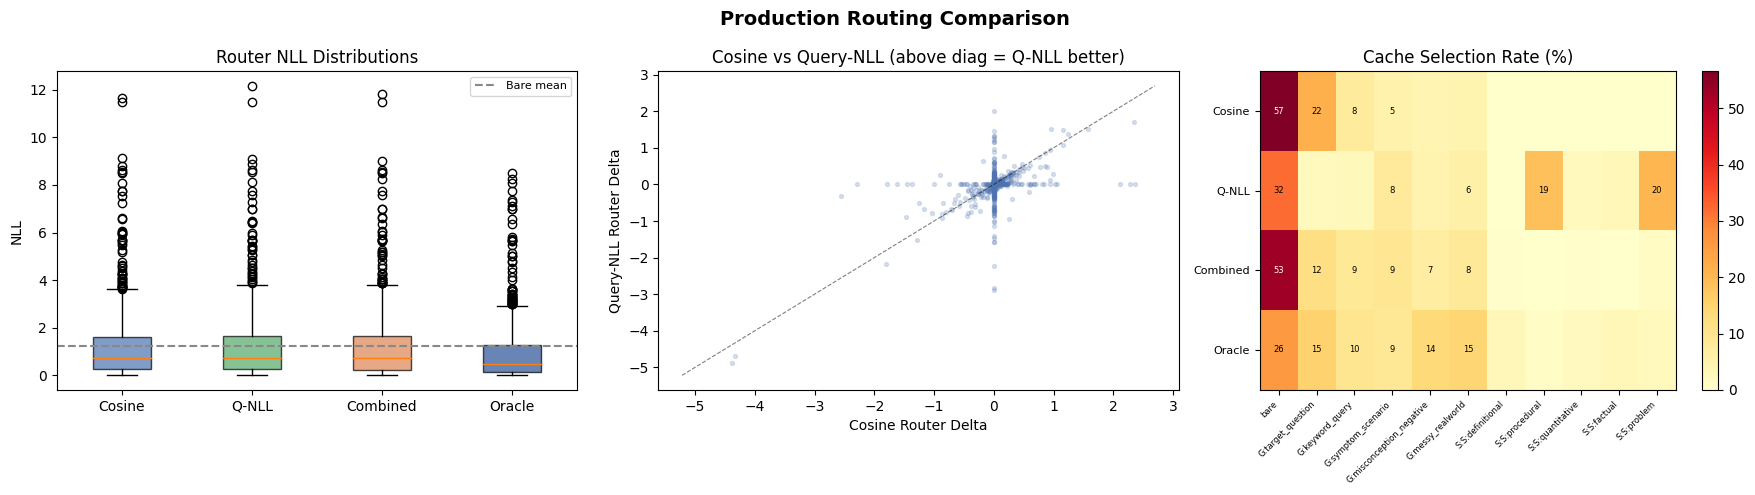

Saved: 06_routing_comparison.png


In [17]:
# Routing comparison figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Production Routing Comparison', fontsize=14, fontweight='bold')

# (0) Router NLL distributions
ax = axes[0]
router_data = [
    np.array([r['pool_cosine_nll'] for r in results]),
    np.array([r['pool_qnll_nll'] for r in results]),
    np.array([r['pool_combined_nll'] for r in results]),
    np.array([r['pool_oracle_nll'] for r in results]),
]
bp = ax.boxplot(router_data, labels=['Cosine', 'Q-NLL', 'Combined', 'Oracle'], patch_artist=True)
for patch, c in zip(bp['boxes'], ['#4c72b0', '#55a868', '#dd8452', '#2a5298']):
    patch.set_facecolor(c)
    patch.set_alpha(0.7)
ax.axhline(np.mean(bare_arr), color='#888888', linestyle='--', label='Bare mean')
ax.set_ylabel('NLL')
ax.set_title('Router NLL Distributions')
ax.legend(fontsize=8)

# (1) Cosine vs Query-NLL scatter
ax = axes[1]
ax.scatter(cosine_deltas, qnll_deltas, alpha=0.2, s=8, c='#4c72b0')
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Cosine Router Delta')
ax.set_ylabel('Query-NLL Router Delta')
ax.set_title('Cosine vs Query-NLL (above diag = Q-NLL better)')

# (2) Cache selection heatmap
ax = axes[2]
from collections import Counter
all_cache_keys = list(pool_caches.keys()) if 'pool_caches' in dir() else ['bare'] + [f'gen_{k}' for k in TOP_5_SURROGATE_TEMPLATES] + [f'static_{k}' for k in STATIC_SURROGATE_QUERIES]
# Use first result to get pool keys
all_cache_keys = list(results[0]['pool_answer_nlls'].keys())
router_labels = ['Cosine', 'Q-NLL', 'Combined', 'Oracle']
router_key_fields = ['pool_cosine_key', 'pool_qnll_key', 'pool_combined_key', 'pool_oracle_key']

selection_matrix = np.zeros((len(router_labels), len(all_cache_keys)))
for ri, rk in enumerate(router_key_fields):
    counts = Counter(r[rk] for r in results)
    for ci, ck in enumerate(all_cache_keys):
        selection_matrix[ri, ci] = counts.get(ck, 0) / len(results) * 100

im = ax.imshow(selection_matrix, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(all_cache_keys)))
ax.set_xticklabels([k.replace('gen_', 'G:').replace('static_', 'S:') for k in all_cache_keys],
                    fontsize=6, rotation=45, ha='right')
ax.set_yticks(range(len(router_labels)))
ax.set_yticklabels(router_labels, fontsize=8)
ax.set_title('Cache Selection Rate (%)')
plt.colorbar(im, ax=ax)

# Annotate cells with values > 5%
for ri in range(len(router_labels)):
    for ci in range(len(all_cache_keys)):
        val = selection_matrix[ri, ci]
        if val > 5:
            ax.text(ci, ri, f'{val:.0f}', ha='center', va='center', fontsize=6,
                    color='white' if val > 40 else 'black')

plt.tight_layout()
plt.savefig('06_routing_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 06_routing_comparison.png")

## Save Results

In [18]:
output = {
    'metadata': {
        'experiment': '06_semantic_priming_hypothesis_test',
        'description': (
            'Rigorous semantic priming hypothesis test with 16 conditions: '
            'bare + framed baselines, 7 truncated variants (generated/oracle/perfect/'
            'irrelevant/shuffled/random_passage/random_tokens), 3 full-context controls, '
            'and 4 pool routing strategies (cosine/query-NLL/combined/oracle).'
        ),
        'timestamp': datetime.datetime.now().isoformat(),
        'model_name': config.model_name,
        'num_samples_requested': config.num_samples,
        'num_samples_evaluated': len(results),
        'num_errors': errors,
        'elapsed_seconds': elapsed_total,
        'seed': config.seed,
        'filters': {
            'excluded_ratio': excluded_ratio,
            'excluded_short_answer': excluded_short_answer,
        },
    },
    'results': results,
}

output_path = '06_semantic_priming_results.json'
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)
print(f"Results saved to {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1e6:.1f} MB")

Results saved to 06_semantic_priming_results.json
File size: 2.8 MB


## Conclusions

In [19]:
print("=" * 80)
print("AUTOMATED VERDICTS")
print("=" * 80)

alpha = 0.01
bonferroni_alpha = alpha / 5

verdicts = {}

# H1: Does surrogate priming help?
gen_arr = np.array([r['gen_routed_nll'] for r in results])
t, p = stats.ttest_rel(bare_arr, gen_arr)
verdicts['H1: Surrogate priming helps'] = {
    'test': 'Gen routed (3) vs Bare (1)',
    'bare_mean': float(np.mean(bare_arr)),
    'gen_mean': float(np.mean(gen_arr)),
    'delta': float(np.mean(bare_arr - gen_arr)),
    't': float(t), 'p': float(p),
    'significant': p < bonferroni_alpha,
    'verdict': 'SUPPORTED' if p < bonferroni_alpha and np.mean(gen_arr) < np.mean(bare_arr) else 'NOT SUPPORTED'
}

# H2: Semantic content matters (gen vs irrelevant)
irrel_arr = np.array([r['irrel_nll'] for r in results])
t, p = stats.ttest_rel(gen_arr, irrel_arr)
verdicts['H2: Semantic content matters'] = {
    'test': 'Gen routed (3) vs Irrelevant (6)',
    'gen_mean': float(np.mean(gen_arr)),
    'irrel_mean': float(np.mean(irrel_arr)),
    'delta': float(np.mean(irrel_arr - gen_arr)),
    't': float(t), 'p': float(p),
    'significant': p < bonferroni_alpha,
    'verdict': 'SUPPORTED' if p < bonferroni_alpha and np.mean(gen_arr) < np.mean(irrel_arr) else 'NOT SUPPORTED'
}

# H3: Word order matters (gen vs shuffled)
shuf_arr = np.array([r['shuffled_nll'] for r in results])
t, p = stats.ttest_rel(gen_arr, shuf_arr)
verdicts['H3: Word order matters'] = {
    'test': 'Gen routed (3) vs Shuffled (7)',
    'gen_mean': float(np.mean(gen_arr)),
    'shuffled_mean': float(np.mean(shuf_arr)),
    'delta': float(np.mean(shuf_arr - gen_arr)),
    't': float(t), 'p': float(p),
    'significant': p < bonferroni_alpha,
    'verdict': 'SUPPORTED' if p < bonferroni_alpha and np.mean(gen_arr) < np.mean(shuf_arr) else 'NOT SUPPORTED'
}

# H4: Coherent text matters (gen vs random passage)
rp_arr = np.array([r['rand_passage_nll'] for r in results])
t, p = stats.ttest_rel(gen_arr, rp_arr)
verdicts['H4: Topic relevance > any coherent text'] = {
    'test': 'Gen routed (3) vs Random passage (8)',
    'gen_mean': float(np.mean(gen_arr)),
    'rand_passage_mean': float(np.mean(rp_arr)),
    'delta': float(np.mean(rp_arr - gen_arr)),
    't': float(t), 'p': float(p),
    'significant': p < bonferroni_alpha,
    'verdict': 'SUPPORTED' if p < bonferroni_alpha and np.mean(gen_arr) < np.mean(rp_arr) else 'NOT SUPPORTED'
}

# H5: Coherence matters (gen vs random tokens)
rt_arr = np.array([r['rand_tokens_nll'] for r in results])
t, p = stats.ttest_rel(gen_arr, rt_arr)
verdicts['H5: Coherence matters'] = {
    'test': 'Gen routed (3) vs Random tokens (9)',
    'gen_mean': float(np.mean(gen_arr)),
    'rand_tokens_mean': float(np.mean(rt_arr)),
    'delta': float(np.mean(rt_arr - gen_arr)),
    't': float(t), 'p': float(p),
    'significant': p < bonferroni_alpha,
    'verdict': 'SUPPORTED' if p < bonferroni_alpha and np.mean(gen_arr) < np.mean(rt_arr) else 'NOT SUPPORTED'
}

# H6: Full-context benefit is semantic
full_gen_arr = np.array([r['full_gen_nll'] for r in results])
full_irrel_arr = np.array([r['full_irrel_nll'] for r in results])
t, p = stats.ttest_rel(full_gen_arr, full_irrel_arr)
verdicts['H6: Full-context benefit is semantic'] = {
    'test': 'Full-ctx gen (10) vs Full-ctx irrel (11)',
    'gen_mean': float(np.mean(full_gen_arr)),
    'irrel_mean': float(np.mean(full_irrel_arr)),
    'delta': float(np.mean(full_irrel_arr - full_gen_arr)),
    't': float(t), 'p': float(p),
    'significant': p < 0.05,
    'verdict': 'SUPPORTED' if p < 0.05 and np.mean(full_gen_arr) < np.mean(full_irrel_arr) else 'NOT SUPPORTED'
}

# H7: Query-NLL routing > cosine routing
cosine_arr = np.array([r['pool_cosine_nll'] for r in results])
qnll_arr = np.array([r['pool_qnll_nll'] for r in results])
t, p = stats.ttest_rel(cosine_arr, qnll_arr)
verdicts['H7: Query-NLL routing > Cosine routing'] = {
    'test': 'Pool cosine (13) vs Pool query-NLL (14)',
    'cosine_mean': float(np.mean(cosine_arr)),
    'qnll_mean': float(np.mean(qnll_arr)),
    'delta': float(np.mean(cosine_arr - qnll_arr)),
    't': float(t), 'p': float(p),
    'significant': p < 0.05,
    'verdict': 'SUPPORTED' if p < 0.05 and np.mean(qnll_arr) < np.mean(cosine_arr) else 'NOT SUPPORTED'
}

# Print verdicts
for hyp, v in verdicts.items():
    sig_marker = "***" if v['significant'] else "   "
    print(f"\n{sig_marker} {hyp}: {v['verdict']}")
    print(f"    {v['test']}")
    print(f"    t={v['t']:.3f}, p={v['p']:.6f}")

# Oracle ceiling
oracle_arr = np.array([r['pool_oracle_nll'] for r in results])
oracle_delta = np.mean(bare_arr - oracle_arr)
t_oracle, p_oracle = stats.ttest_rel(bare_arr, oracle_arr)
print(f"\n--- Oracle Ceiling ---")
print(f"Pool oracle mean NLL: {np.mean(oracle_arr):.4f}")
print(f"Delta vs bare: {oracle_delta:+.4f} (t={t_oracle:.3f}, p={p_oracle:.6f})")
print(f"Win rate: {np.mean(bare_arr > oracle_arr)*100:.1f}%")

print("\n" + "=" * 80)

AUTOMATED VERDICTS

    H1: Surrogate priming helps: NOT SUPPORTED
    Gen routed (3) vs Bare (1)
    t=0.493, p=0.622158

*** H2: Semantic content matters: SUPPORTED
    Gen routed (3) vs Irrelevant (6)
    t=-3.532, p=0.000441

    H3: Word order matters: NOT SUPPORTED
    Gen routed (3) vs Shuffled (7)
    t=-1.325, p=0.185696

    H4: Topic relevance > any coherent text: NOT SUPPORTED
    Gen routed (3) vs Random passage (8)
    t=1.135, p=0.256654

*** H5: Coherence matters: SUPPORTED
    Gen routed (3) vs Random tokens (9)
    t=-5.022, p=0.000001

*** H6: Full-context benefit is semantic: NOT SUPPORTED
    Full-ctx gen (10) vs Full-ctx irrel (11)
    t=2.156, p=0.031470

    H7: Query-NLL routing > Cosine routing: NOT SUPPORTED
    Pool cosine (13) vs Pool query-NLL (14)
    t=-1.931, p=0.053881

--- Oracle Ceiling ---
Pool oracle mean NLL: 0.9685
Delta vs bare: +0.2613 (t=15.660, p=0.000000)
Win rate: 74.0%

